# ACA Phoneme Recognition: Neural Network

Using the MFCC data obtained from TIMIT using MATLAB, we now implement a neural network for classification.

## Loading the Keras package
We begin by loading keras and the other packages

In [1]:
import keras

Using TensorFlow backend.


In [2]:
import numpy as np
import scipy.io
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

## Load the Data

The MFCC data was processed in MATLAB. Labels have been converted to integers.

In [3]:
data_dir = 'ACA/'
train = scipy.io.loadmat(data_dir+'phn_train_scaled.mat')
test = scipy.io.loadmat(data_dir+'phn_test_scaled.mat')
train_label = scipy.io.loadmat(data_dir+'phn_train_int_label.mat')
test_label = scipy.io.loadmat(data_dir+'phn_test_int_label.mat')
Xtr = train['data'].T
ytr = train_label['train_label'][0,0].T
Xts = test['data'].T
yts = test_label['test_label'][0,0].T

* What is the number of training and test samples?
* What is the number of features for each sample?
* How many classes (i.e. instruments) are their per class.


In [4]:
ntr = Xtr.shape[0]
nts = Xts.shape[0]
print('Number of training samples: {0:d}'.format(ntr))
print('Number of test samples: {0:d}'.format(nts))
print('Number of features: {0:d}'.format(Xtr.shape[1]))
print('Number of classes: {0:d}'.format((np.unique(yts)).shape[0]))

Number of training samples: 177080
Number of test samples: 64145
Number of features: 72
Number of classes: 61


## Building a Neural Network Classifier

Clear the keras session.

In [5]:
from keras.models import Model, Sequential
from keras.layers import Dense, Activation

In [6]:
import keras.backend as K
K.clear_session()

Create a neural network `model` with:
* `nh=256` hidden units
* `sigmoid` activation

In [7]:
nin = Xtr.shape[1]
nh = 512 # Number of hidden units
nout = int((np.unique(yts)).shape[0]+1)
model = Sequential()
model.add(Dense(nh, input_shape=(nin,), activation='sigmoid', name='hidden'))
model.add(Dense(nout, activation='softmax', name='output'))

Print the model summary.

In [8]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden (Dense)               (None, 512)               37376     
_________________________________________________________________
output (Dense)               (None, 62)                31806     
Total params: 69,182
Trainable params: 69,182
Non-trainable params: 0
_________________________________________________________________


To keep track of the loss history and validation accuracy, we use a *callback* function as described in [Keras callback documentation](https://keras.io/callbacks/).

In [9]:
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        # Create two empty lists, self.loss and self.val_acc
        self.loss = []
        self.val_acc = []
 
    def on_batch_end(self, batch, logs={}):
        # This is called at the end of each batch.  
        # Add the loss in logs.get('loss') to the loss list
        self.loss.append(logs.get('loss'))
        
    def on_epoch_end(self, epoch, logs):
        # This is called at the end of each epoch.  
        # Add the test accuracy in logs.get('val_acc') to the val_acc list
        self.val_acc.append(logs.get('val_acc'))

# Create an instance of the history callback
history_cb = LossHistory()

Create an optimizer using the Adam optimizer with a learning rate of 0.001. Then, compile the model.

In [10]:
from keras import optimizers

opt = optimizers.Adam(lr=0.001)
model.compile(optimizer=opt,
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

Fit the model for 25 epochs using the scaled data for both the training and validation. Use a batch size of 100. 

In [11]:
model.fit(Xtr, ytr, epochs=25, batch_size = 100, validation_data=(Xts,yts), callbacks=[history_cb])

Train on 177080 samples, validate on 64145 samples
Epoch 1/25
177080/177080 [==============================] - 32s - loss: 2.0262 - acc: 0.4290 - val_loss: 1.7349 - val_acc: 0.4825.429
Epoch 2/25
177080/177080 [==============================] - 31s - loss: 1.6584 - acc: 0.4987 - val_loss: 1.6464 - val_acc: 0.5019
Epoch 3/25
177080/177080 [==============================] - 31s - loss: 1.5792 - acc: 0.5174 - val_loss: 1.5991 - val_acc: 0.5105
Epoch 4/25
177080/177080 [==============================] - 31s - loss: 1.5125 - acc: 0.5345 - val_loss: 1.5294 - val_acc: 0.5311
Epoch 5/25
177080/177080 [==============================] - 31s - loss: 1.4497 - acc: 0.5526 - val_loss: 1.4694 - val_acc: 0.5489
Epoch 6/25
177080/177080 [==============================] - 31s - loss: 1.3955 - acc: 0.5659 - val_loss: 1.4293 - val_acc: 0.5596
Epoch 7/25
177080/177080 [==============================] - 31s - loss: 1.3482 - acc: 0.5794 - val_loss: 1.4062 - val_acc: 0.5623
Epoch 8/25
177080/177080 [=========

Plot the validation accuracy saved in the `history_cb`. This gives one accuracy value per epoch.

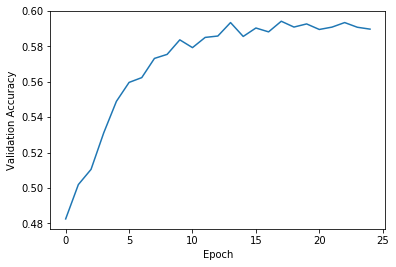

In [12]:
plt.plot(history_cb.val_acc)
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.show()

Plot the loss values saved in the `history_cb` class.

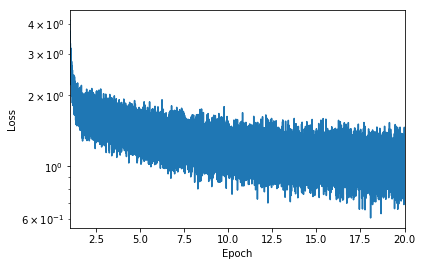

In [13]:
plt.semilogy(np.linspace(1,20,44275),history_cb.loss)
plt.xlabel('Epoch')
plt.xlim([1,20])
plt.ylabel('Loss')
plt.show()

64100/64145 [============================>.] - ETA: 0s[[ 0.615  0.026  0.06  ...,  0.     0.     0.   ]
 [ 0.016  0.802  0.017 ...,  0.     0.     0.   ]
 [ 0.043  0.041  0.367 ...,  0.     0.     0.   ]
 ..., 
 [ 0.     0.     0.    ...,  0.492  0.001  0.   ]
 [ 0.     0.     0.    ...,  0.     0.531  0.054]
 [ 0.     0.     0.    ...,  0.002  0.01   0.095]]


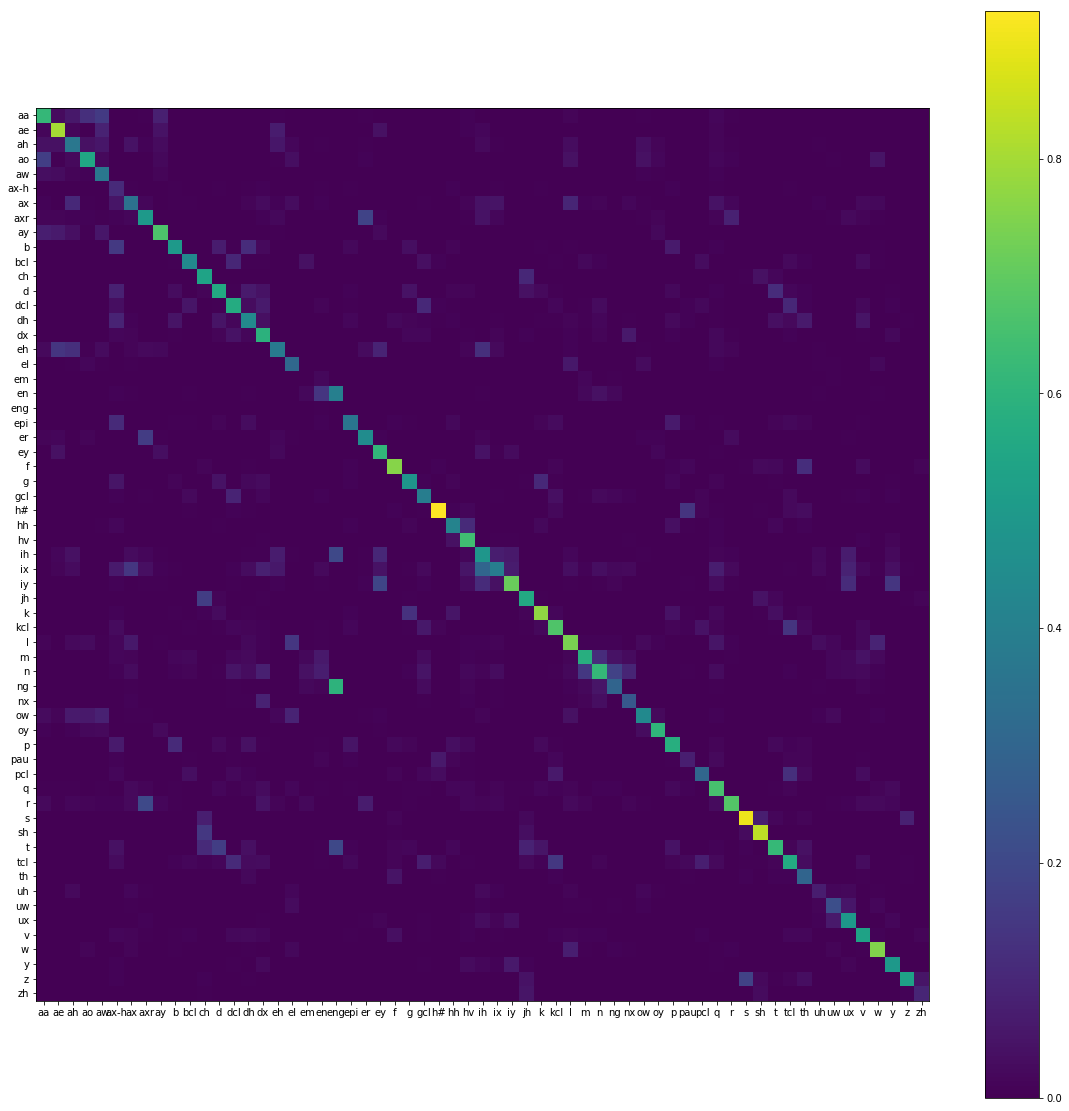

In [14]:
yhat_ts = model.predict(Xts,batch_size=100,verbose=1)
yhat_ts = np.argmax(yhat_ts,axis=1)

from sklearn.metrics import confusion_matrix
C = confusion_matrix(yts,yhat_ts)
Csum = np.sum(C,1)
C = C/Csum[None,:]
print(np.array_str(C,precision=3,suppress_small=True))
fig = plt.figure(figsize = (20,20))
ax = fig.add_subplot(111)
im = ax.imshow(C,interpolation='none')
fig.colorbar(im,ax=ax)
phn = ('aa', 'ae', 'ah', 'ao', 'aw', 'ax-h', 'ax', 'axr', 'ay', 'b', 'bcl', 'ch', 'd', 'dcl', 'dh', 'dx', 'eh', 'el', 'em', 'en', 'eng', 'epi', 'er', 'ey', 'f', 'g', 'gcl', 'h#', 'hh', 'hv', 'ih', 'ix', 'iy', 'jh', 'k', 'kcl', 'l', 'm', 'n', 'ng', 'nx', 'ow', 'oy', 'p', 'pau', 'pcl', 'q', 'r', 's', 'sh', 't', 'tcl', 'th', 'uh', 'uw', 'ux', 'v', 'w', 'y', 'z', 'zh')
xt=plt.xticks(np.arange(np.unique(yts).shape[0]),phn)
yt=plt.yticks(np.arange(np.unique(yts).shape[0]),phn)

fig.savefig('cm-NN-all.png')

# Repeat for other class groups
Halberstadt, 6 groups

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden (Dense)               (None, 512)               37376     
_________________________________________________________________
output (Dense)               (None, 7)                 3591      
Total params: 40,967
Trainable params: 40,967
Non-trainable params: 0
_________________________________________________________________
Train on 177080 samples, validate on 64145 samples
Epoch 1/25
177080/177080 [==============================] - 22s - loss: 0.6127 - acc: 0.7935 - val_loss: 0.5289 - val_acc: 0.8143
Epoch 2/25
177080/177080 [==============================] - 21s - loss: 0.5136 - acc: 0.8223 - val_loss: 0.4884 - val_acc: 0.8327
Epoch 3/25
177080/177080 [==============================] - 21s - loss: 0.4662 - acc: 0.8380 - val_loss: 0.4450 - val_acc: 0.8440
Epoch 4/25
177080/177080 [==============================] - 20s - loss: 0.4243 - acc: 0.8528 

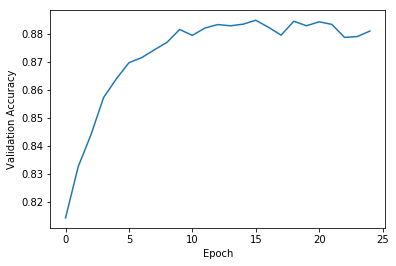

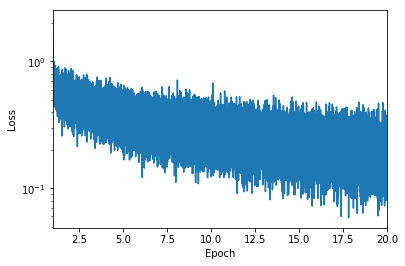

63600/64145 [============================>.] - ETA: 0s[[ 0.957  0.101  0.002  0.037  0.008  0.027]
 [ 0.026  0.772  0.002  0.019  0.012  0.035]
 [ 0.001  0.001  0.959  0.011  0.015  0.004]
 [ 0.011  0.037  0.02   0.553  0.058  0.042]
 [ 0.002  0.022  0.031  0.101  0.809  0.042]
 [ 0.017  0.092  0.014  0.096  0.058  0.868]]


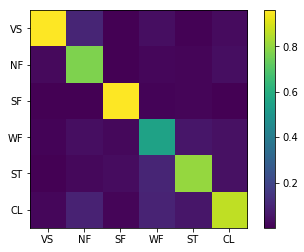

In [20]:
ytr = train_label['train_label'][0,1].T
yts = test_label['test_label'][0,1].T
ntr = Xtr.shape[0]
nts = Xts.shape[0]

K.clear_session()
nin = Xtr.shape[1]
nh = 512 # Number of hidden units
nout = int((np.unique(yts)).shape[0]+1)
model = Sequential()
model.add(Dense(nh, input_shape=(nin,), activation='sigmoid', name='hidden'))
model.add(Dense(nout, activation='softmax', name='output'))
model.summary()
opt = optimizers.Adam(lr=0.001)
model.compile(optimizer=opt,
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

model.fit(Xtr, ytr, epochs=25, batch_size = 100, validation_data=(Xts,yts), callbacks=[history_cb])
plt.plot(history_cb.val_acc)
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.show()
plt.semilogy(np.linspace(1,20,44275),history_cb.loss)
plt.xlabel('Epoch')
plt.xlim([1,20])
plt.ylabel('Loss')
plt.show()

yhat_ts = model.predict(Xts,batch_size=100,verbose=1)
yhat_ts = np.argmax(yhat_ts,axis=1)

C = confusion_matrix(yts,yhat_ts)
Csum = np.sum(C,1)
C = C/Csum[None,:]
print(np.array_str(C,precision=3,suppress_small=True))
plt.imshow(C,interpolation='none')
plt.colorbar()
plt.xticks(np.arange(np.unique(yts).shape[0]),('VS','NF','SF','WF','ST','CL'))
plt.yticks(np.arange(np.unique(yts).shape[0]),('VS','NF','SF','WF','ST','CL'))

plt.savefig('cm-NN-halb1.png')

Halberstadt, 3 broader groups

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden (Dense)               (None, 512)               37376     
_________________________________________________________________
output (Dense)               (None, 4)                 2052      
Total params: 39,428
Trainable params: 39,428
Non-trainable params: 0
_________________________________________________________________
Train on 177080 samples, validate on 64145 samples
Epoch 1/25
177080/177080 [==============================] - 20s - loss: 0.3873 - acc: 0.8645 - val_loss: 0.3394 - val_acc: 0.8809
Epoch 2/25
177080/177080 [==============================] - 19s - loss: 0.3339 - acc: 0.8820 - val_loss: 0.3077 - val_acc: 0.8929
Epoch 3/25
177080/177080 [==============================] - 19s - loss: 0.2991 - acc: 0.8937 - val_loss: 0.2759 - val_acc: 0.9022
Epoch 4/25
177080/177080 [==============================] - 19s - loss: 0.2681 - acc: 0.9040 

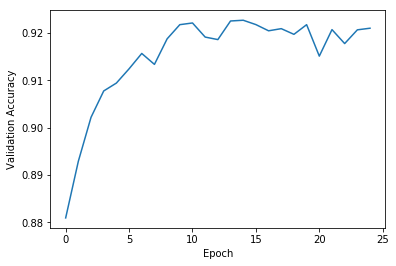

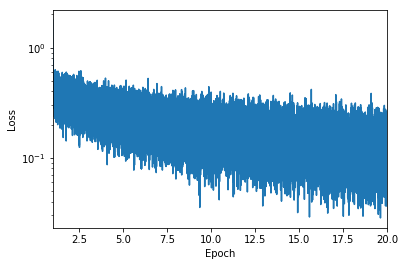

63800/64145 [============================>.] - ETA: 0s[[ 0.967  0.032  0.044]
 [ 0.021  0.892  0.072]
 [ 0.036  0.061  0.845]]


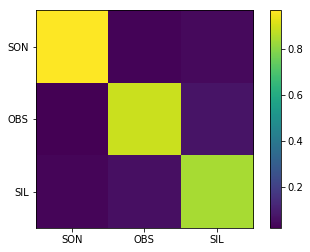

In [21]:
ytr = train_label['train_label'][0,2].T
yts = test_label['test_label'][0,2].T
ntr = Xtr.shape[0]
nts = Xts.shape[0]

K.clear_session()
nin = Xtr.shape[1]
nh = 512 # Number of hidden units
nout = int((np.unique(yts)).shape[0]+1)
model = Sequential()
model.add(Dense(nh, input_shape=(nin,), activation='sigmoid', name='hidden'))
model.add(Dense(nout, activation='softmax', name='output'))
model.summary()
opt = optimizers.Adam(lr=0.001)
model.compile(optimizer=opt,
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

model.fit(Xtr, ytr, epochs=25, batch_size = 100, validation_data=(Xts,yts), callbacks=[history_cb])
plt.plot(history_cb.val_acc)
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.show()
plt.semilogy(np.linspace(1,20,44275),history_cb.loss)
plt.xlabel('Epoch')
plt.xlim([1,20])
plt.ylabel('Loss')
plt.show()

yhat_ts = model.predict(Xts,batch_size=100,verbose=1)
yhat_ts = np.argmax(yhat_ts,axis=1)

C = confusion_matrix(yts,yhat_ts)
Csum = np.sum(C,1)
C = C/Csum[None,:]
print(np.array_str(C,precision=3,suppress_small=True))
plt.imshow(C,interpolation='none')
plt.colorbar()
plt.xticks(np.arange(np.unique(yts).shape[0]),('SON','OBS','SIL'))
plt.yticks(np.arange(np.unique(yts).shape[0]),('SON','OBS','SIL'))

plt.savefig('cm-NN-halb2.png')

Scanlon

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden (Dense)               (None, 512)               37376     
_________________________________________________________________
output (Dense)               (None, 6)                 3078      
Total params: 40,454
Trainable params: 40,454
Non-trainable params: 0
_________________________________________________________________
Train on 177080 samples, validate on 64145 samples
Epoch 1/25
177080/177080 [==============================] - 21s - loss: 0.6024 - acc: 0.7982 - val_loss: 0.5349 - val_acc: 0.8202
Epoch 2/25
177080/177080 [==============================] - 20s - loss: 0.5168 - acc: 0.8233 - val_loss: 0.4989 - val_acc: 0.8292
Epoch 3/25
177080/177080 [==============================] - 21s - loss: 0.4623 - acc: 0.8399 - val_loss: 0.4342 - val_acc: 0.8450
Epoch 4/25
177080/177080 [==============================] - 20s - loss: 0.4113 - acc: 0.8566 

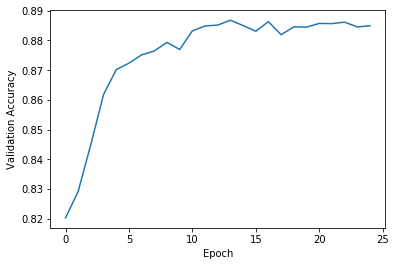

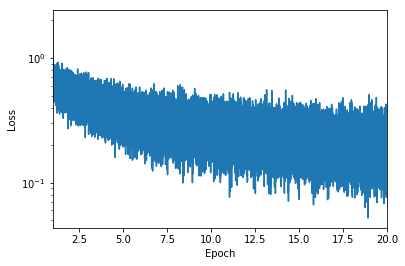

64000/64145 [============================>.] - ETA: 0s[[ 0.964  0.01   0.014  0.071  0.03 ]
 [ 0.004  0.839  0.063  0.008  0.036]
 [ 0.013  0.081  0.791  0.026  0.042]
 [ 0.023  0.007  0.009  0.774  0.026]
 [ 0.028  0.076  0.049  0.088  0.851]]


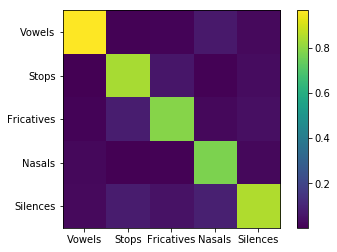

In [22]:
ytr = train_label['train_label'][0,3].T
yts = test_label['test_label'][0,3].T
ntr = Xtr.shape[0]
nts = Xts.shape[0]

K.clear_session()
nin = Xtr.shape[1]
nh = 512 # Number of hidden units
nout = int((np.unique(yts)).shape[0]+1)
model = Sequential()
model.add(Dense(nh, input_shape=(nin,), activation='sigmoid', name='hidden'))
model.add(Dense(nout, activation='softmax', name='output'))
model.summary()
opt = optimizers.Adam(lr=0.001)
model.compile(optimizer=opt,
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

model.fit(Xtr, ytr, epochs=25, batch_size = 100, validation_data=(Xts,yts), callbacks=[history_cb])
plt.plot(history_cb.val_acc)
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.show()
plt.semilogy(np.linspace(1,20,44275),history_cb.loss)
plt.xlabel('Epoch')
plt.xlim([1,20])
plt.ylabel('Loss')
plt.show()

yhat_ts = model.predict(Xts,batch_size=100,verbose=1)
yhat_ts = np.argmax(yhat_ts,axis=1)

C = confusion_matrix(yts,yhat_ts)
Csum = np.sum(C,1)
C = C/Csum[None,:]
print(np.array_str(C,precision=3,suppress_small=True))
plt.imshow(C,interpolation='none')
plt.colorbar()
plt.xticks(np.arange(np.unique(yts).shape[0]),('Vowels','Stops','Fricatives','Nasals','Silences'))
plt.yticks(np.arange(np.unique(yts).shape[0]),('Vowels','Stops','Fricatives','Nasals','Silences'))

plt.savefig('cm-NN-s.png')